# Results and figures for ECML submission

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sb
import pandas as pd

## Synthetic data

In [2]:
feature_types = ['colors', 'sbm', 'lowrank5', 'lowrank8', 'lowrank12']
loss_parts = ['adj', 'feat', 'total loss', 'reg', 'kl']
synthetic_id_vars = ['correlation', 'spill', 'dimξ', 'sample']

synthetic = {}
synthetic['colors'] = pd.read_csv('../../data/behaviour/colors/'
                                  'nnodes=1000-sharedl1=false-decadjdeep=true-'
                                  'model=ov-correlation=0:0.1:1-spill=-9:9-dimxi=10:2:20-nsamples=20.csv.gz',
                                  compression='gzip')
synthetic['sbm'] = pd.read_csv('../../data/behaviour/sbmfeatures/'
                               'nnodes=1000-sharedl1=false-decadjdeep=true-'
                               'model=ov-correlation=0:0.1:1-spill=-9:9-dimxi=10:2:20-nsamples=20.csv.gz',
                               compression='gzip')
synthetic['lowrank5'] = pd.read_csv('../../data/behaviour/lowrank/'
                                    'nnodes=1000-sharedl1=false-decadjdeep=true-rank=5-'
                                    'model=ov-correlation=0:0.1:1-spill=-9:9-dimxi=10:2:20-nsamples=20.csv.gz',
                                    compression='gzip')
synthetic['lowrank8'] = pd.read_csv('../../data/behaviour/lowrank/'
                                    'nnodes=1000-sharedl1=false-decadjdeep=true-rank=8-'
                                    'model=ov-correlation=0:0.1:1-spill=-9:9-dimxi=10:2:20-nsamples=20.csv.gz',
                                    compression='gzip')
synthetic['lowrank12'] = pd.read_csv('../../data/behaviour/lowrank/'
                                     'nnodes=1000-sharedl1=false-decadjdeep=true-rank=12-'
                                     'model=ov-correlation=0:0.1:1-spill=-9:9-dimxi=10:2:20-nsamples=20.csv.gz',
                                     compression='gzip')

In [3]:
def reduce_best_totalloss(df, id_vars, val_vars):
    best_total_wide = df\
        .groupby(id_vars)\
        .apply(lambda x: x.loc[x['total loss'].idxmin()])\
        .reset_index(drop=True)
    best_total_wide = best_total_wide[id_vars + val_vars]
    return pd.melt(best_total_wide,
                   id_vars=id_vars,
                   var_name='loss', value_name='best_total')

In [4]:
synthetic_best = {}
for feature_type in feature_types:
    synthetic_best[feature_type] = reduce_best_totalloss(synthetic[feature_type], synthetic_id_vars, loss_parts)

In [5]:
def relov(df, id_vars, val_vars):
    maxdimξ = df.dimξ.max()
    rel = pd.pivot_table(df, index=id_vars, columns='loss').reset_index()
    rel.columns = id_vars + list(filter(lambda s: len(s) > 0, rel.columns.droplevel()))
    rel[val_vars] = rel\
        .groupby(['spill', 'correlation'])\
        .apply(lambda x: x / x[x.dimξ == maxdimξ].mean())[val_vars]
    rel_long = pd.melt(rel,
                       id_vars=id_vars,
                       var_name='loss', value_name='best_total')
    return rel_long

In [6]:
synthetic_best_relov = {}
for feature_type in feature_types:
    synthetic_best_relov[feature_type] = relov(synthetic_best[feature_type], synthetic_id_vars, loss_parts)

Asymmetrical allocation is better than symmetrical. Seen for different overlap levels (0 $\rightarrow$ 8 by steps of 2).

/home/slerique/anaconda3/envs/base36-gpu/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


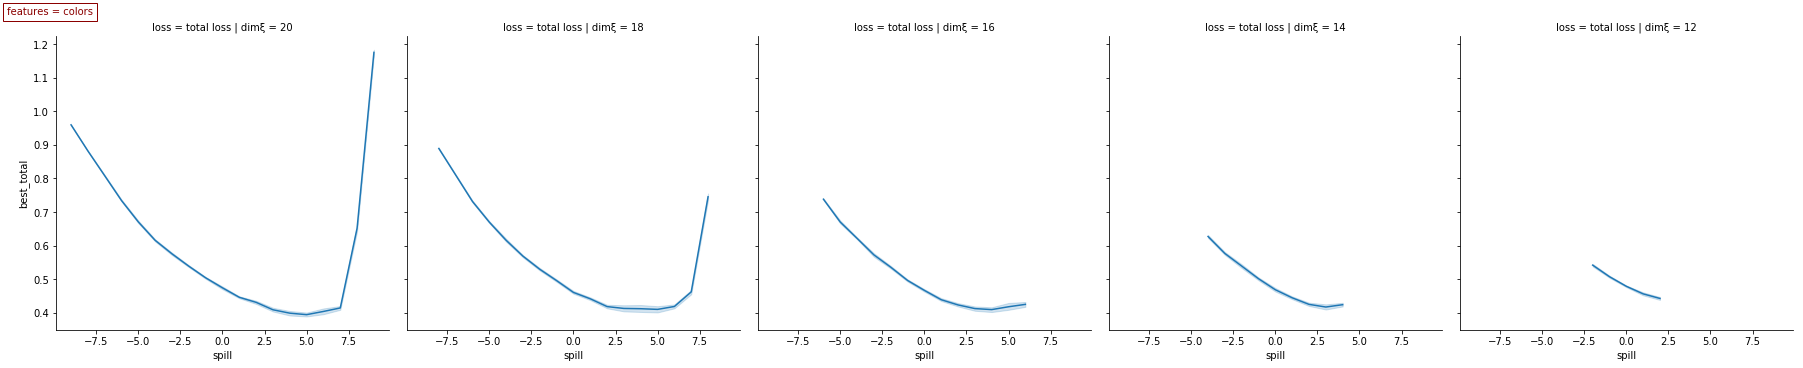

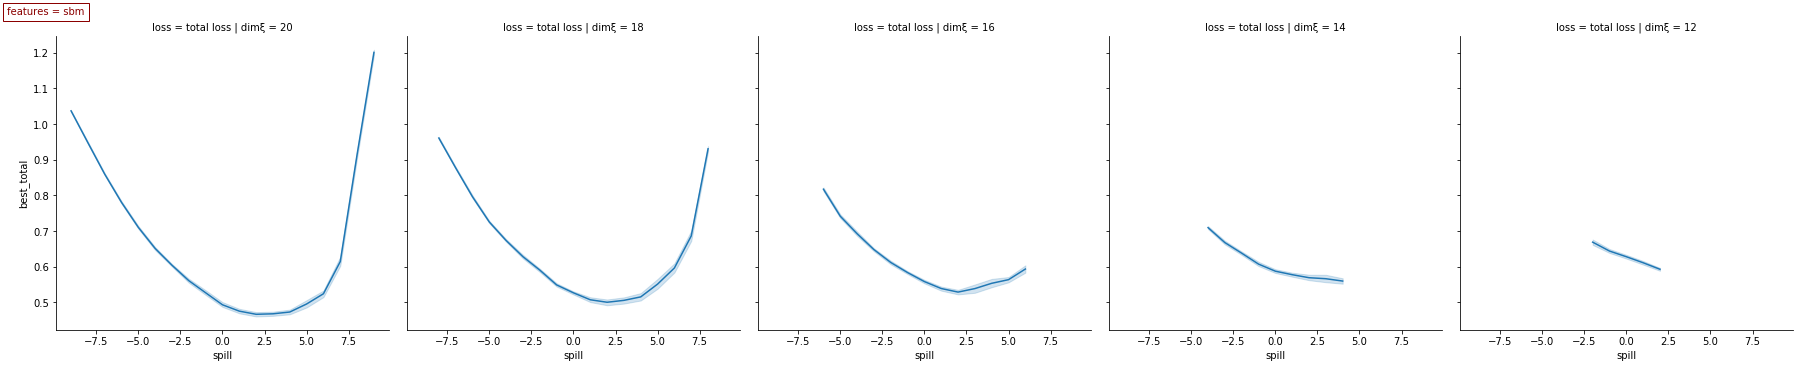

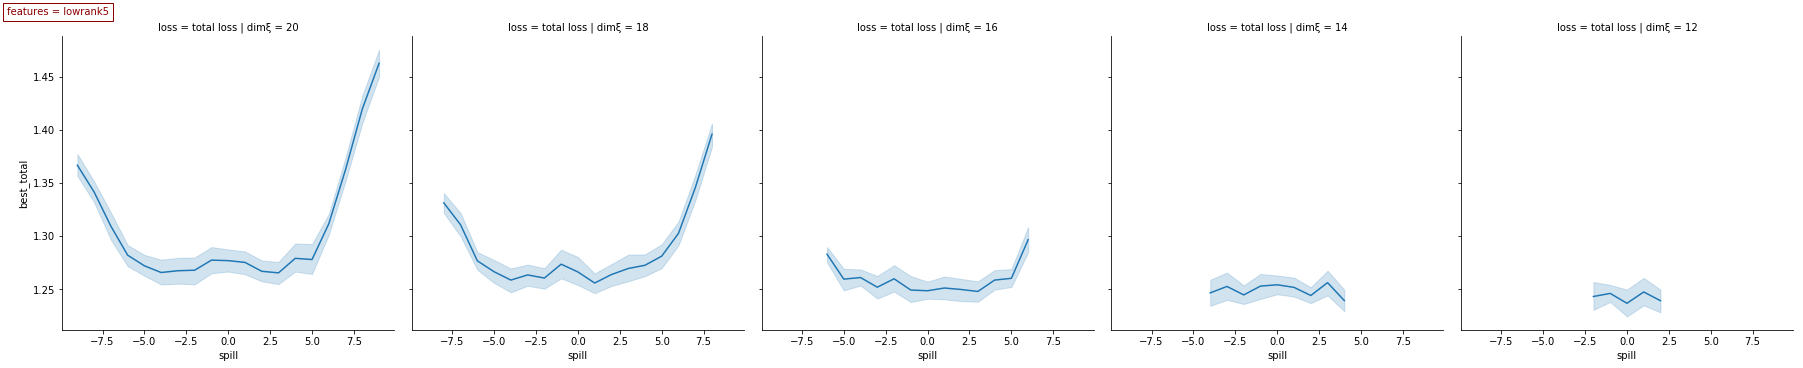

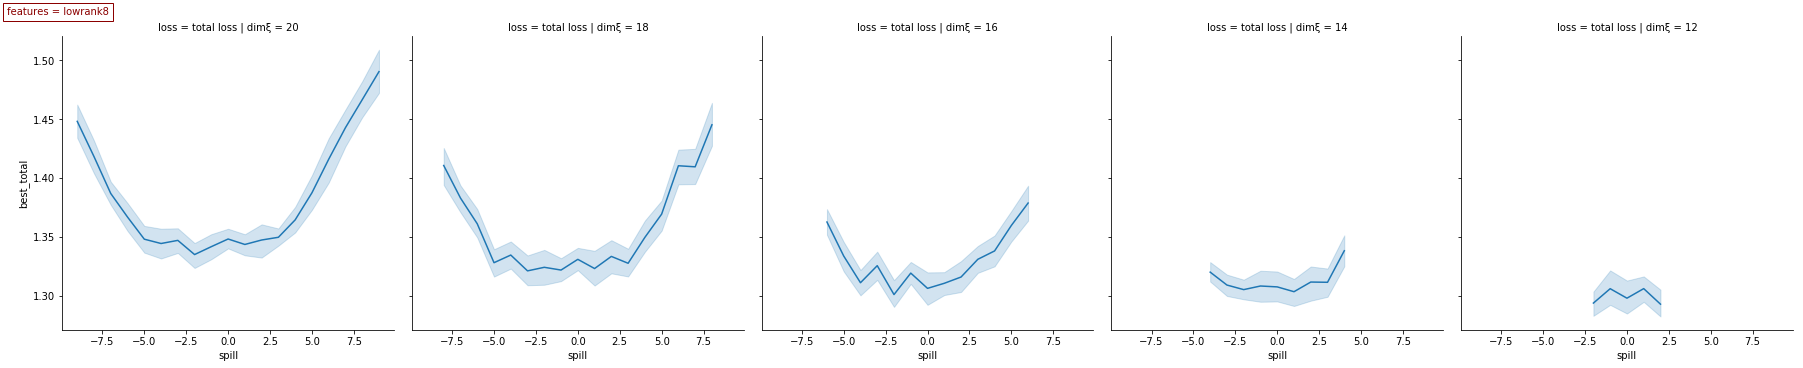

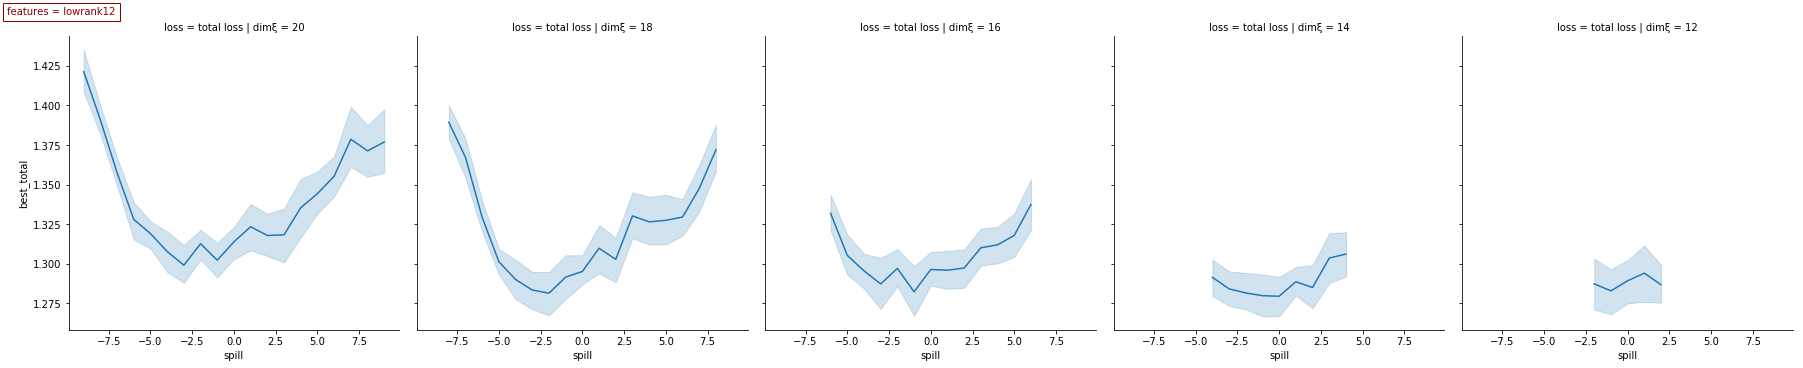

In [7]:
for feature_type in feature_types:
    df = synthetic_best[feature_type]
    fg = sb.relplot(x='spill', y='best_total',
                    col='dimξ', col_order=range(20, 11, -2),
                    row='loss', row_order=['total loss'],
                    data=df[df.correlation == 1.0],
                    kind='line', legend='full', facet_kws={'sharey': True})
    fg.fig.text(0, 1, 'features = {}'.format(feature_type),
                color='darkred', ha='left', va='center',
                bbox={'edgecolor': 'darkred', 'facecolor': "#00000000"})

When varying the correlation, having overlap benefits more

First in absolute values

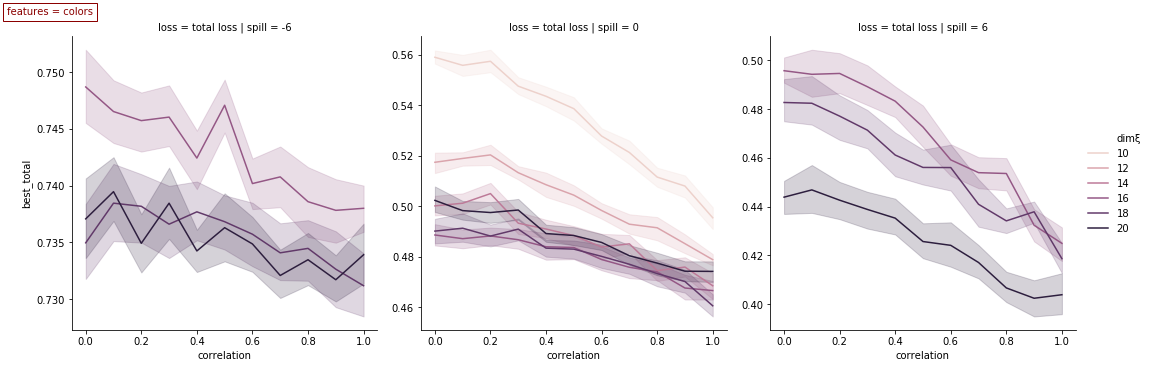

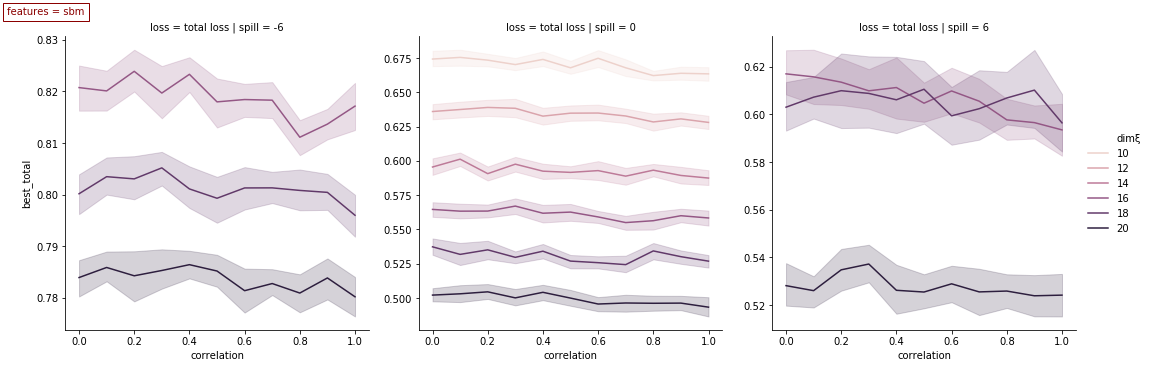

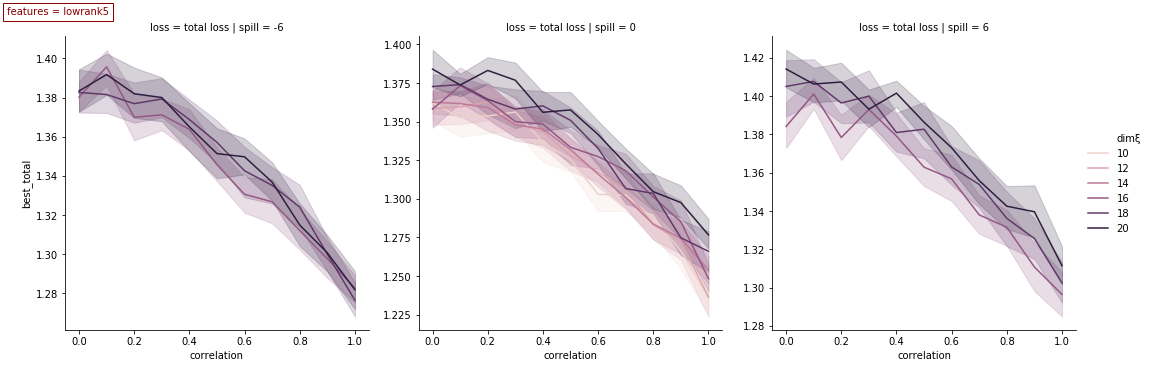

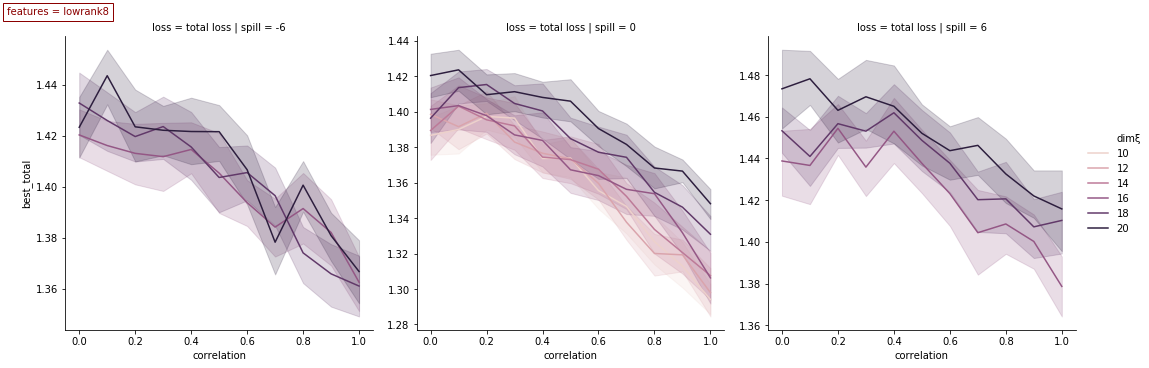

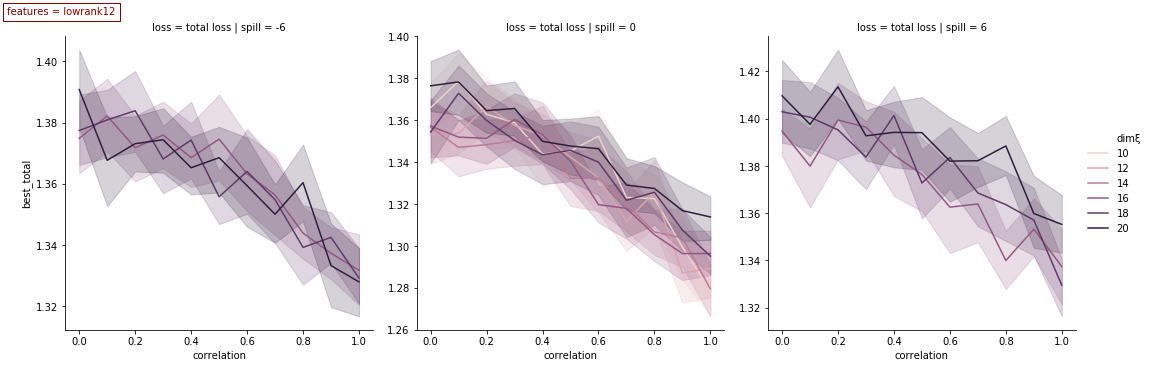

In [8]:
for feature_type in feature_types:
    df = synthetic_best[feature_type]
    fg = sb.relplot(x='correlation', y='best_total',
                    col='spill', col_order=[-6, 0, 6],
                    hue='dimξ',
                    row='loss', row_order=['total loss'],#, 'adj', 'feat'],
                    data=df,
                    kind='line', legend='full', facet_kws={'sharey': False})
    fg.fig.text(0, 1, 'features = {}'.format(feature_type),
                color='darkred', ha='left', va='center',
                bbox={'edgecolor': 'darkred', 'facecolor': "#00000000"})

Then in relative values (relative to 0 overlap)

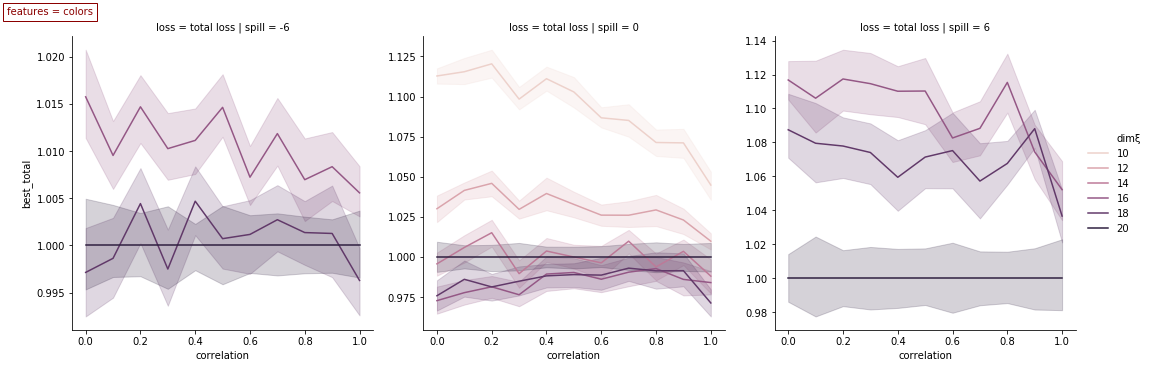

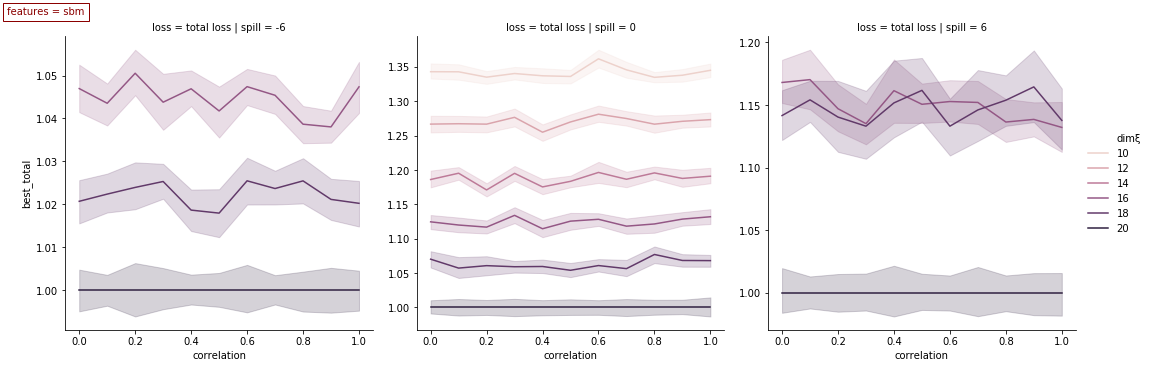

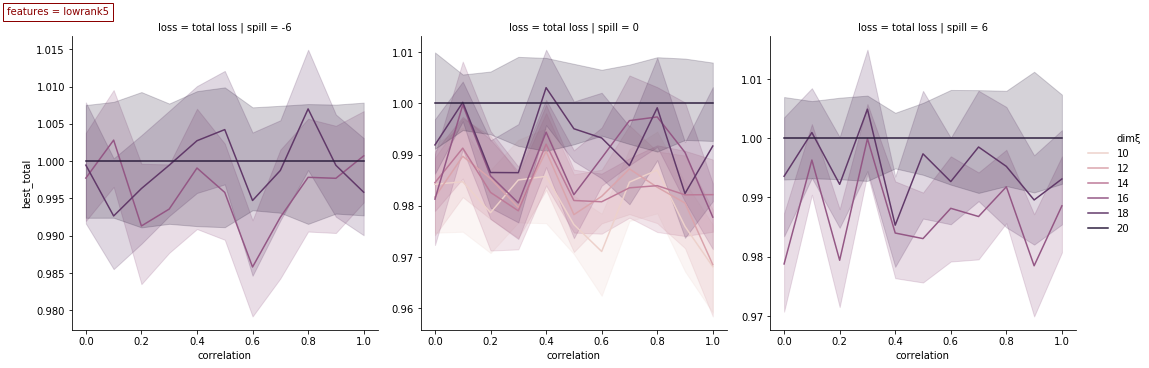

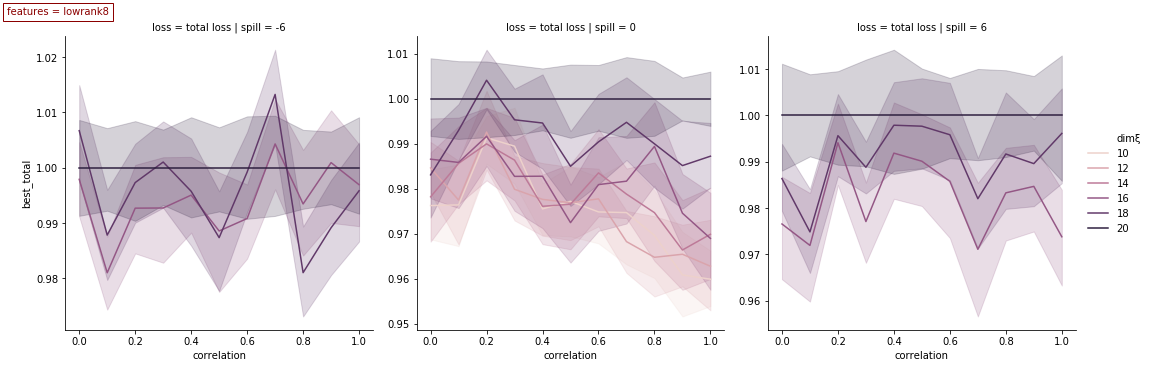

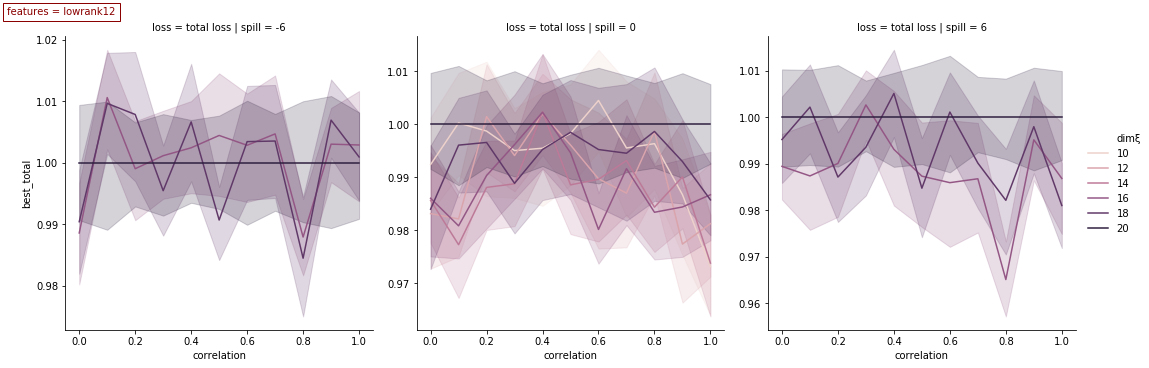

In [9]:
for feature_type in feature_types:
    df = synthetic_best_relov[feature_type]
    fg = sb.relplot(x='correlation', y='best_total',
                    col='spill', col_order=[-6, 0, 6],
                    hue='dimξ',
                    row='loss', row_order=['total loss'],
                    data=df,
                    kind='line', legend='full', facet_kws={'sharey': False})
    fg.fig.text(0, 1, 'features = {}'.format(feature_type),
                color='darkred', ha='left', va='center',
                bbox={'edgecolor': 'darkred', 'facecolor': "#00000000"})

We can also 3D-plot the spill/correlation variations, for different overlap levels

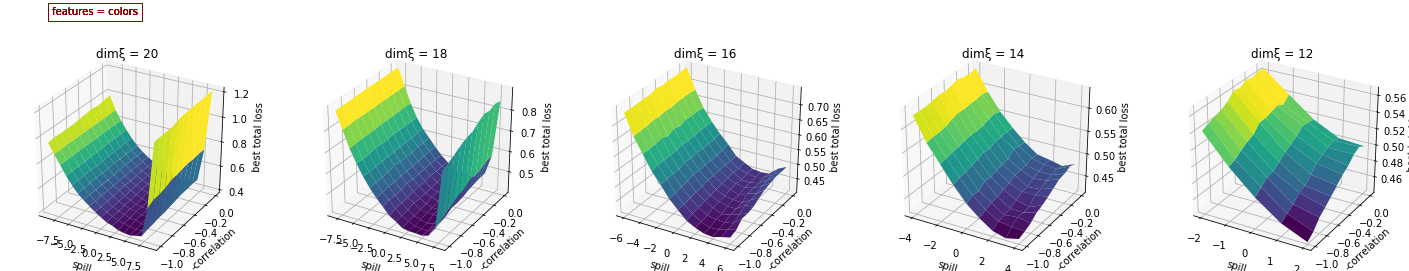

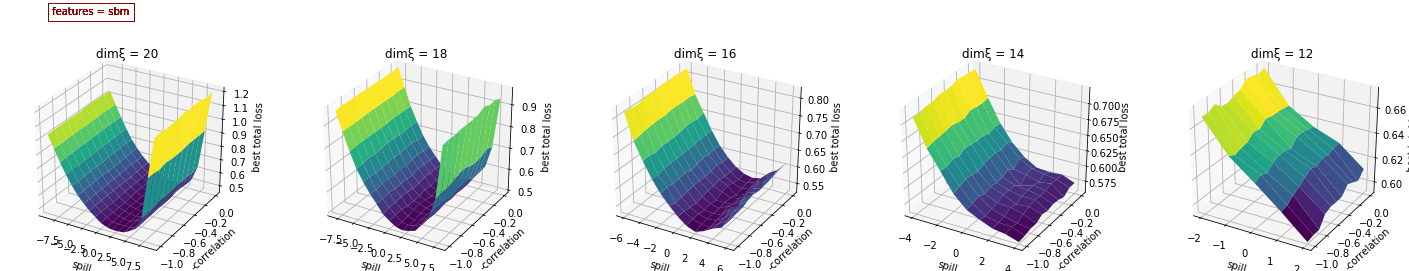

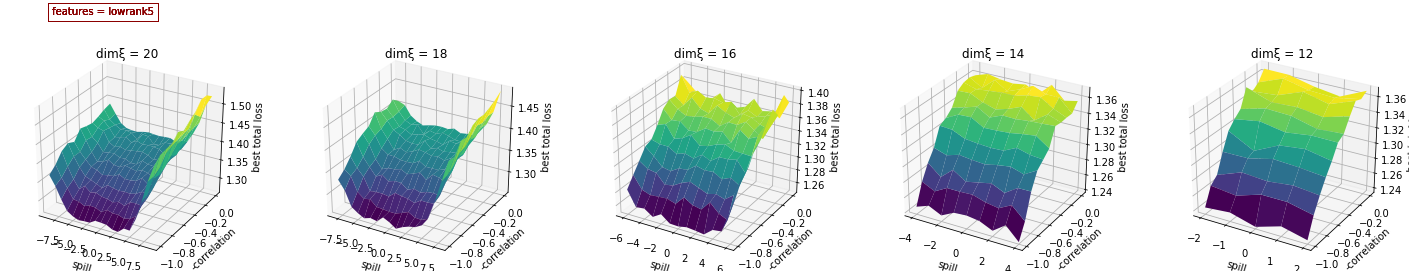

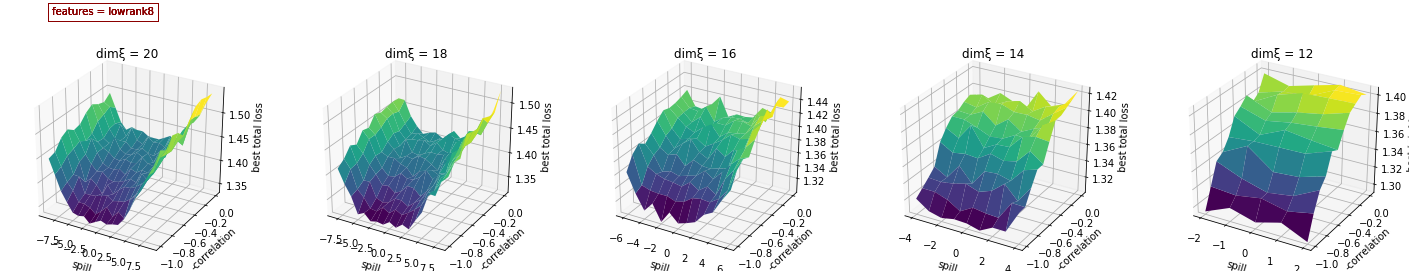

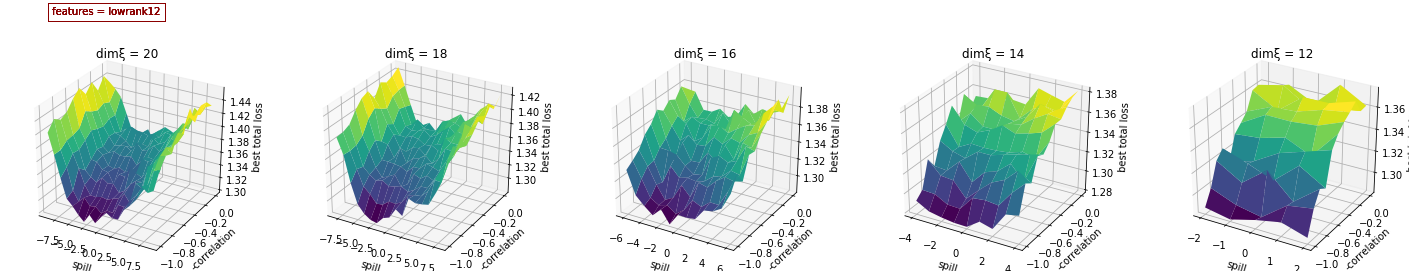

In [10]:
for feature_type in feature_types:
    fig, axes = plt.subplots(1, 5, subplot_kw={'projection': '3d'}, figsize=(25, 4))
    
    for ax, dimξ in zip(axes, range(20, 11, -2)):        
        df = synthetic_best[feature_type]
        df = df.groupby(['correlation', 'spill', 'dimξ', 'loss']).mean().reset_index()
        df = df[(df.loss == 'total loss') & (df.dimξ == dimξ)].sort_values(by=['spill', 'correlation'])
        xlen = len(np.unique(df.spill))
        ylen = len(np.unique(df.correlation))
        x = np.reshape(np.array(df.spill), (xlen, ylen))
        y = - np.reshape(np.array(df.correlation), (xlen, ylen))
        z = np.reshape(np.array(df.best_total), (xlen, ylen))

        ax.plot_surface(x, y, z, cmap='viridis')
        ax.set_xlabel('spill')
        ax.set_ylabel('-correlation')
        ax.set_zlabel('best total loss')
        ax.set_title('dimξ = {}'.format(dimξ))
        fig.text(0.15, 1, 'features = {}'.format(feature_type),
                 color='darkred', ha='left', va='center',
                 bbox={'edgecolor': 'darkred', 'facecolor': "#00000000"})

## Real data

TODO:
* add pubmed for LP once it's done computing
* add 3D plot with spill/correlation for cora once it's done computing
* add state-of-the-art values wherever available

In [11]:
real_id_vars = ['spill', 'dimξ', 'sample']
datasets_lp = ['cora', 'citeseer']#, 'pubmed']
datasets_nc = ['cora', 'citeseer', 'pubmed']

real_lp = {}
real_lp['cora'] = pd.read_csv('../../data/behaviour/gae-benchmarks/'
                              'lp-bias=false-sharedl1=false-decadjdeep=true-dataset=cora-'
                              'testprop=0.15-spill=-15:15-dimxi=16:2:32-nsamples=10.csv.gz',
                              compression='gzip')
real_lp['citeseer'] = pd.read_csv('../../data/behaviour/gae-benchmarks/'
                                  'lp-bias=false-sharedl1=false-decadjdeep=true-dataset=citeseer-clean-'
                                  'testprop=0.15-spill=-15:15-dimxi=16:8:32-nsamples=10.csv.gz',
                                  compression='gzip')
#real_lp['pubmed'] = pd.read_csv('../../data/behaviour/gae-benchmarks/'
#                                'lp-bias=false-sharedl1=false-decadjdeep=true-dataset=pubmed-'
#                                'testprop=0.15-spill=-15:15-dimxi=16:8:32-nsamples=10.csv.gz',
#                                compression='gzip')

real_nc = {}
real_nc['cora'] = pd.read_csv('../../data/behaviour/gae-benchmarks/'
                              'nc-bias=false-sharedl1=false-decadjdeep=true-dataset=cora-'
                              'testprop=0.15-spill=-15:15-dimxi=16:2:32-nsamples=10.csv.gz',
                              compression='gzip')
real_nc['citeseer'] = pd.read_csv('../../data/behaviour/gae-benchmarks/'
                                  'nc-bias=false-sharedl1=false-decadjdeep=true-dataset=citeseer-clean-'
                                  'testprop=0.15-spill=-15:15-dimxi=16:8:32-nsamples=10.csv.gz',
                                  compression='gzip')
real_nc['pubmed'] = pd.read_csv('../../data/behaviour/gae-benchmarks/'
                                'nc-bias=false-sharedl1=false-decadjdeep=true-dataset=pubmed-'
                                'testprop=0.15-spill=-15:15-dimxi=16:8:32-nsamples=10.csv.gz',
                                compression='gzip')

We find the best asymmetry level for each dataset, and with different overlaps it varies

In [12]:
real_lp_last = {}
for dataset in datasets_lp:
    df = real_lp[dataset]
    cols = real_id_vars + loss_parts + ['auc', 'ap']
    real_lp_last[dataset] = pd.melt(df[df.epoch == df.epoch.max()][cols],
                                    id_vars=real_id_vars,
                                    var_name='loss', value_name='last')

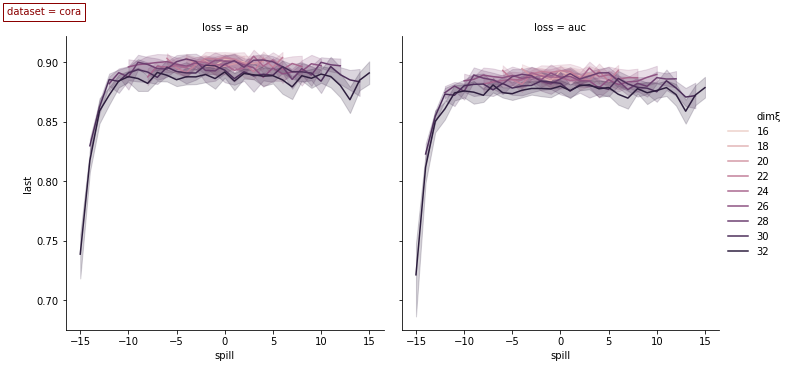

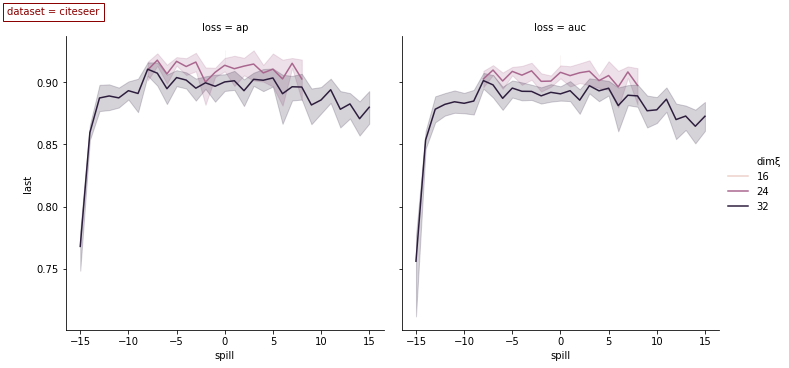

In [13]:
for dataset in datasets_lp:
    df = real_lp_last[dataset]
    fg = sb.relplot(x='spill', y='last',
                    hue='dimξ', hue_order=[32, 24, 16],
                    col='loss', col_order=['ap', 'auc'],
                    data=df,
                    kind='line', legend='full', facet_kws={'sharey': True})
    fg.fig.text(0, 1, 'dataset = {}'.format(dataset),
                color='darkred', ha='left', va='center',
                bbox={'edgecolor': 'darkred', 'facecolor': "#00000000"})

In [14]:
real_nc_last = {}
for dataset in datasets_nc:
    df = real_nc[dataset]
    cols = real_id_vars + loss_parts + ['f1macro', 'f1micro']
    real_nc_last[dataset] = pd.melt(df[df.epoch == df.epoch.max()][cols],
                                    id_vars=real_id_vars,
                                    var_name='loss', value_name='last')

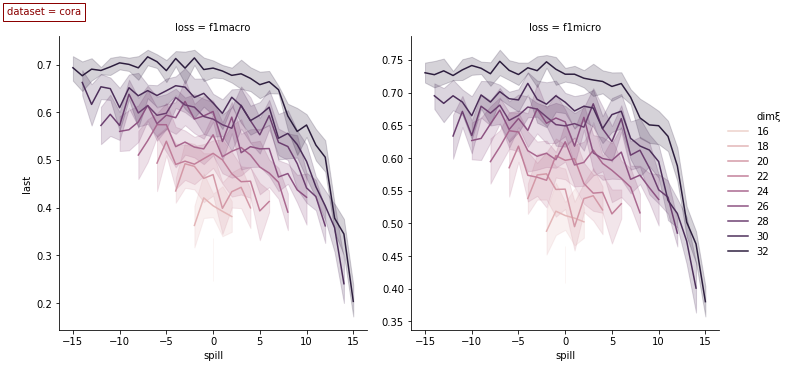

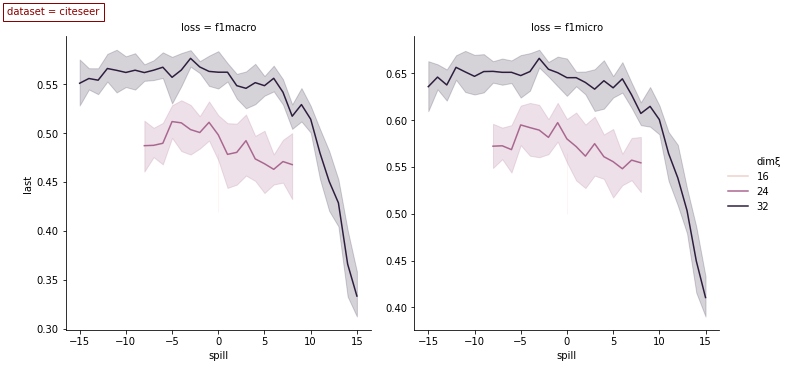

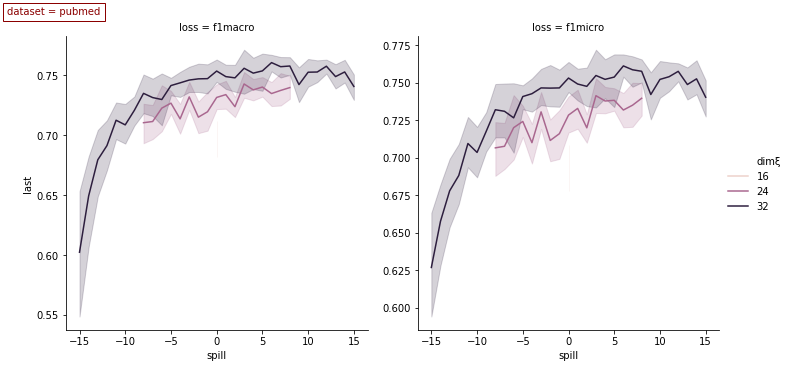

In [15]:
for dataset in datasets_nc:
    df = real_nc_last[dataset]
    fg = sb.relplot(x='spill', y='last',
                    hue='dimξ', hue_order=[32, 24, 16],
                    col='loss', col_order=['f1macro', 'f1micro'],
                    data=df,
                    kind='line', legend='full', facet_kws={'sharey': False})
    fg.fig.text(0, 1, 'dataset = {}'.format(dataset),
                color='darkred', ha='left', va='center',
                bbox={'edgecolor': 'darkred', 'facecolor': "#00000000"})